In [4]:
import numpy as np
import pandas as pd
import requests
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Step 1
Plot neighborhoods using folium

In [6]:
nhood_data = pd.read_csv("neighborhood_data.csv")
print(nhood_data)
# define the dataframe columns
columns = ['Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = nhood_data[columns]

     Neighborhood   Latitude  Longitude
0    Bannerghatta  12.888500  77.597300
1       Jayanagar  12.929273  77.582423
2     Koramangala  12.934011  77.622230
3        Chickpet  12.968003  77.578642
4     Indiranagar  12.973291  77.640467
5   Doddanekkundi  12.975720  77.694042
6       Yelahanka  13.100698  77.596345
7    Mahadevapura  13.012700  77.703000
8     Malleswaram  13.008100  77.564800
9     Fraser Town  12.997200  77.614300
10     Whitefield  12.969000  77.750900
11      Bellandur  12.924300  77.672200


In [7]:
address = 'Bangalore, Karnataka'
geolocator = Nominatim(user_agent="blr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [8]:
# create map of Blr using latitude and longitude values
map_blr = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,  neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blr)  
    
map_blr

## Step 2
Given a neghborhood:
1. get all venues within 2 kms
2. plot them using folium
3. analyze top 10 type of venues using barplots

In [22]:
CLIENT_ID = 'ZNHS4DM5L4KSIE03Q5VGD5Y3RG3A0TM5DEXPRT4GYQFMJW0F' # your Foursquare ID
CLIENT_SECRET = 'FVBQHVIKQSOLN305ULVEEA41TN15ZU2EHT1LOY14ZRMHLZVB' # your Foursquare Secret
VERSION = '20210719' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 2000

In [23]:
neighborhoods.reset_index(inplace=True)

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
blr_venues = getNearbyVenues(names = neighborhoods['Neighborhood'],
                                   latitudes = neighborhoods['Latitude'],
                                   longitudes = neighborhoods['Longitude']
                                  )

Bannerghatta
Jayanagar
Koramangala
Chickpet
Indiranagar
Doddanekkundi
Yelahanka
Mahadevapura
Malleswaram
Fraser Town
Whitefield
Bellandur


In [26]:
blr_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bannerghatta,12.8885,77.5973,Decathlon Sports India Pvt Ltd,12.887513,77.597712,Sporting Goods Shop
1,Bannerghatta,12.8885,77.5973,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop
2,Bannerghatta,12.8885,77.5973,Chavadi,12.892199,77.602538,BBQ Joint
3,Bannerghatta,12.8885,77.5973,Swensens,12.876071,77.595542,Ice Cream Shop
4,Bannerghatta,12.8885,77.5973,Hakuna Matata,12.894028,77.586509,Lounge


In [27]:
venue_grps = blr_venues.groupby(by='Neighborhood')

In [28]:
all_nhoods = list(venue_grps.groups.keys())

In [86]:
# create map of venues in a neighborhood using latitude and longitude values
def map_nhood( grp ):    
    name = grp['Neighborhood'].iloc[0]
    latitude = grp['Neighborhood Latitude'].iloc[0]
    longitude = grp['Neighborhood Longitude'].iloc[0]
    map_venue = folium.Map(location=[latitude, longitude], zoom_start=13)
    # add markers to map
    for lat, lng, venue in zip(grp['Venue Latitude'], grp['Venue Longitude'], grp['Venue Category']):
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venue)  
    map_venue.save(name + '.html')
    return(map_venue)


In [122]:
def analyze_nhood(grp):
    name = grp['Neighborhood'].iloc[0]
    grps = grp.groupby(by='Venue Category').count().iloc[:,0].sort_values(ascending = False).iloc[0:10]
    plt.figure(figsize=(15,10))
    ax = grps.plot(kind='bar')
    ax.set_title(name)
    ax.set_ylabel('Count')
    plt.savefig(name + '.png')
    plt.show()
    

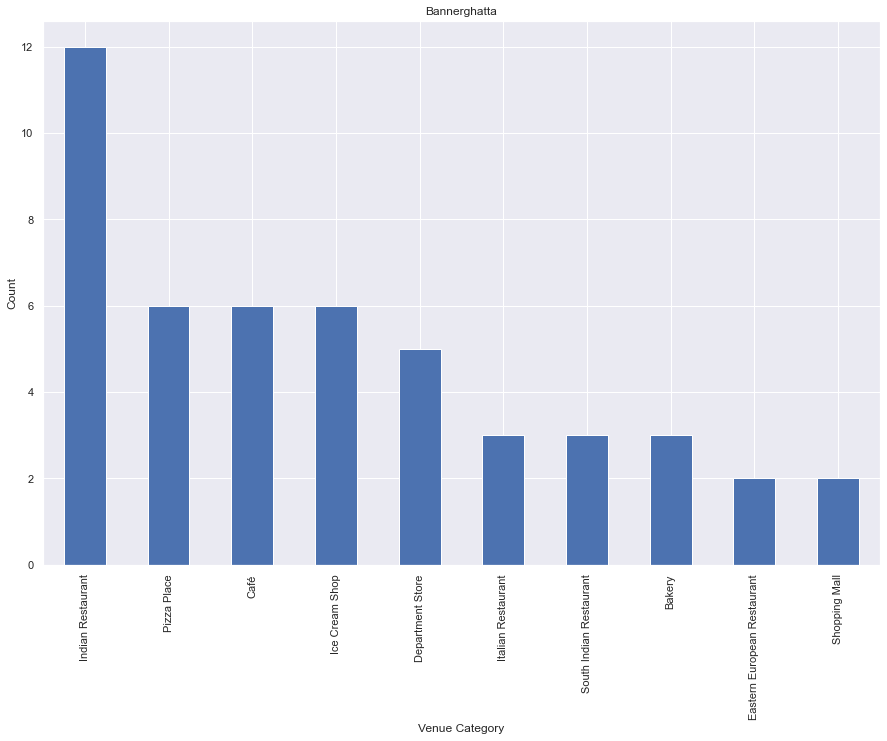

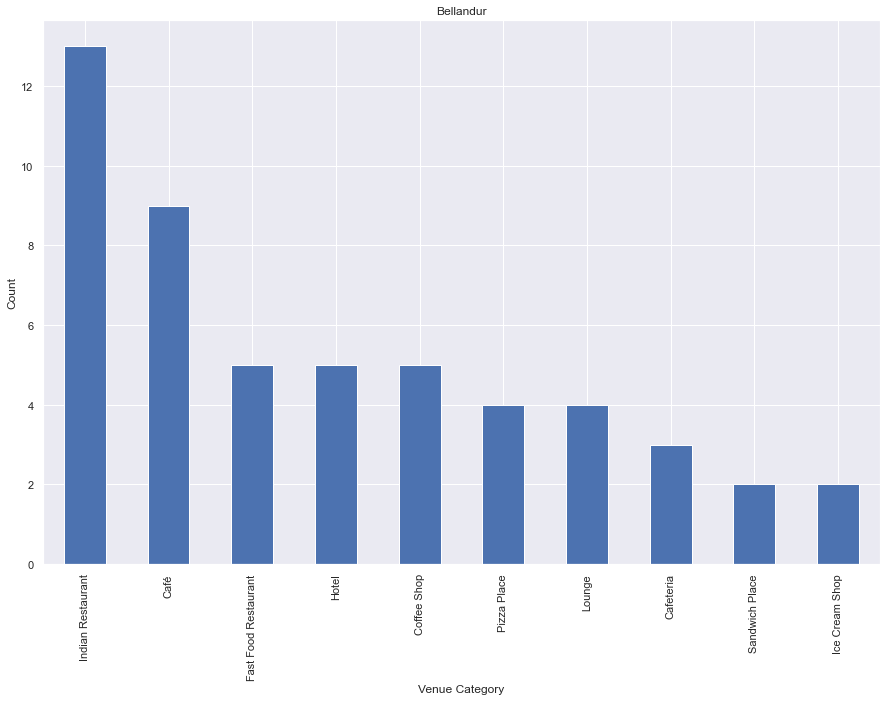

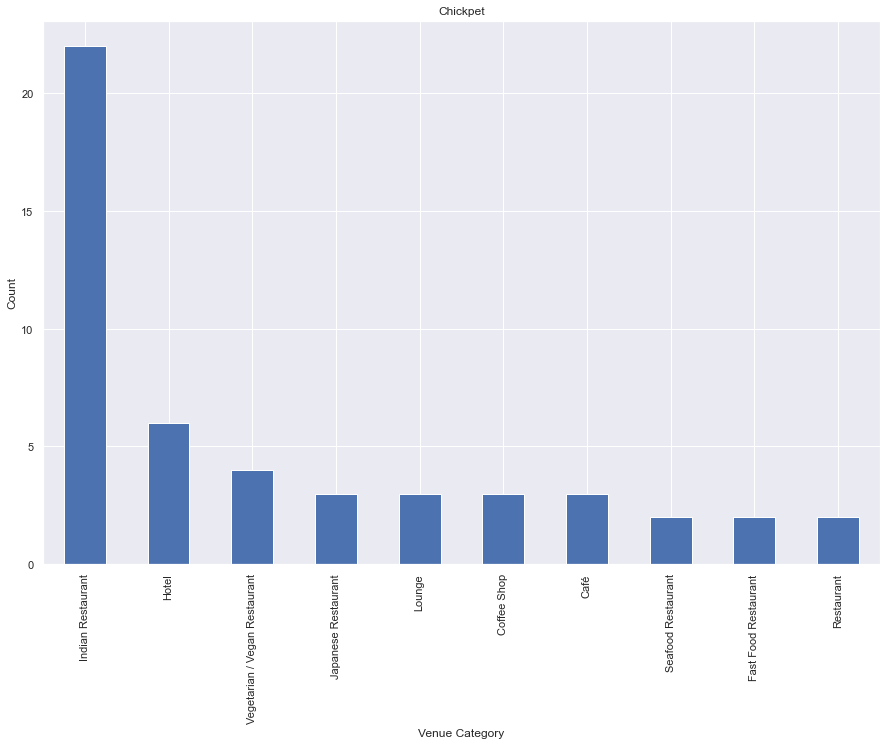

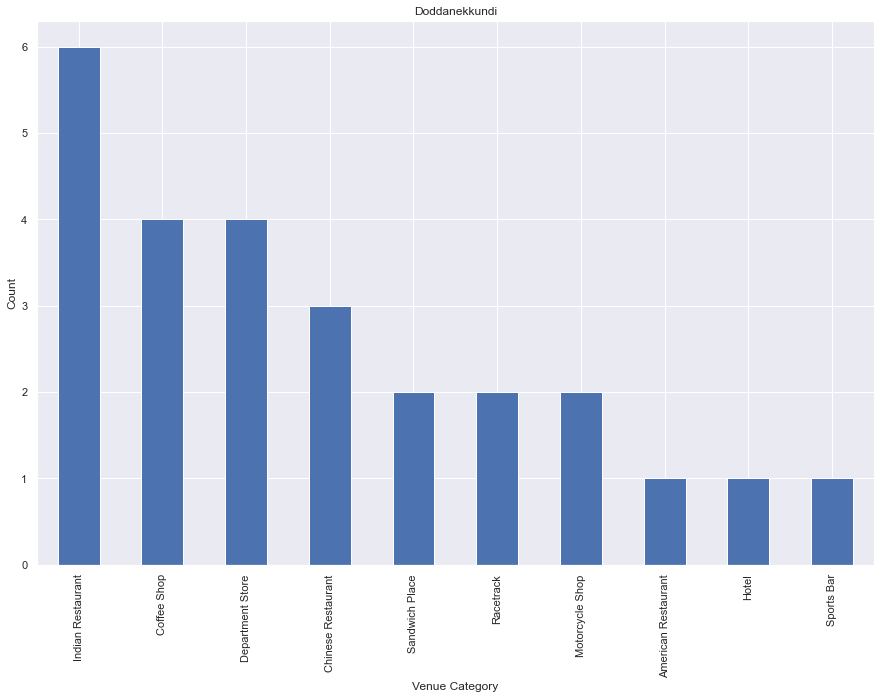

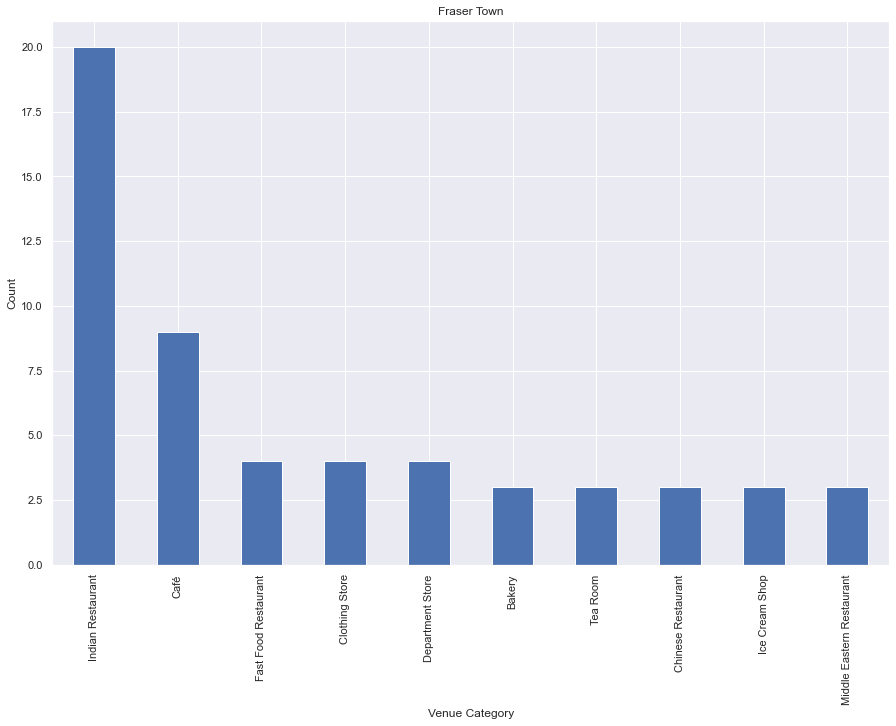

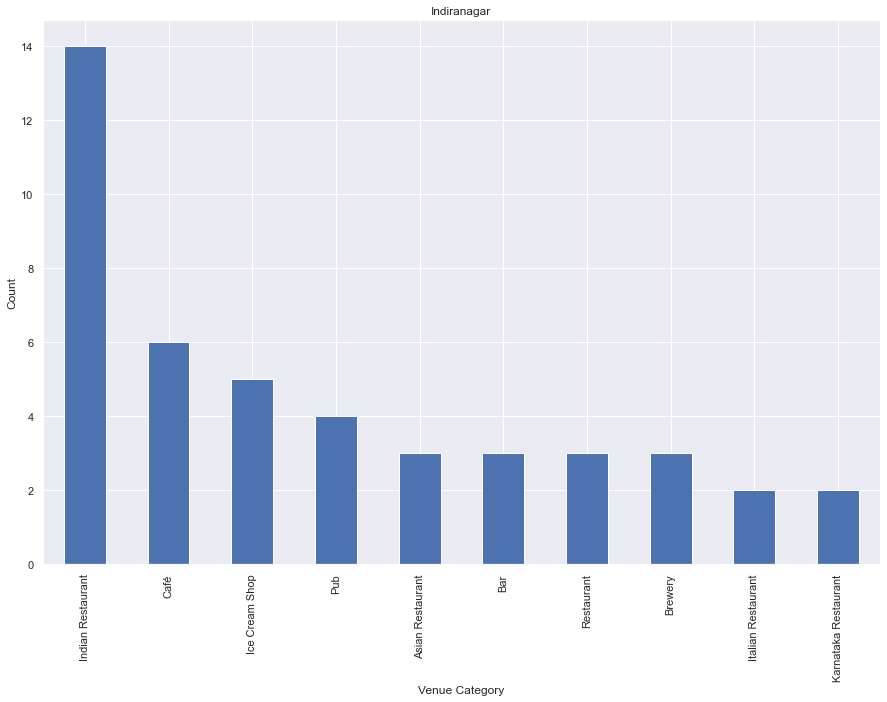

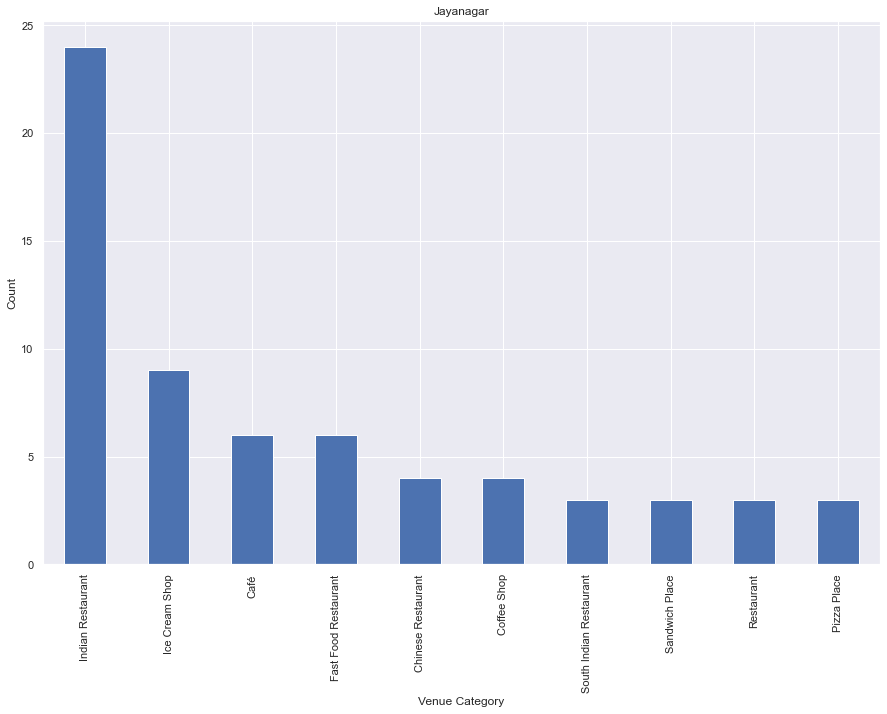

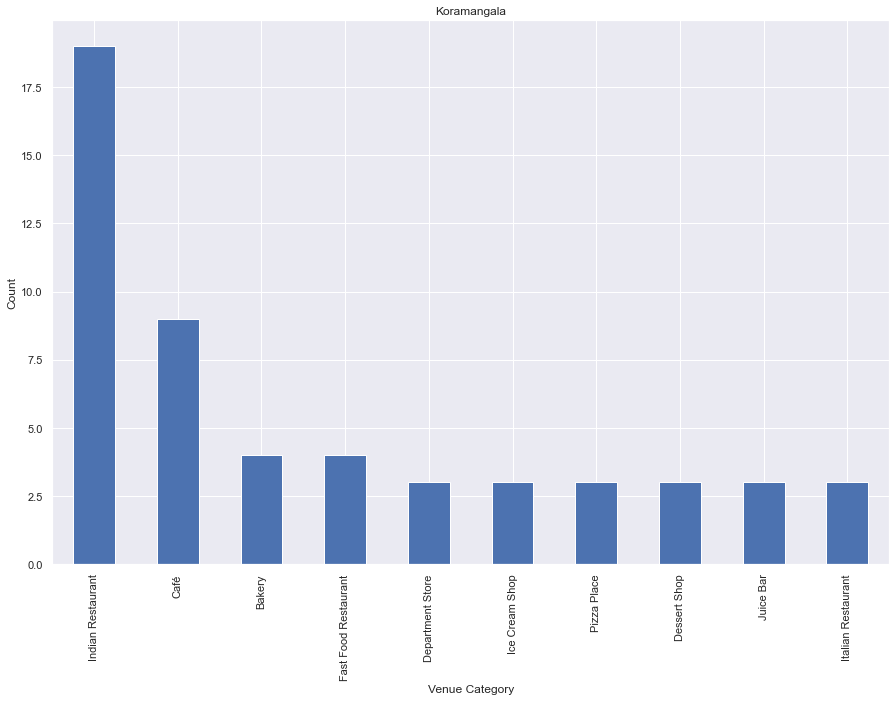

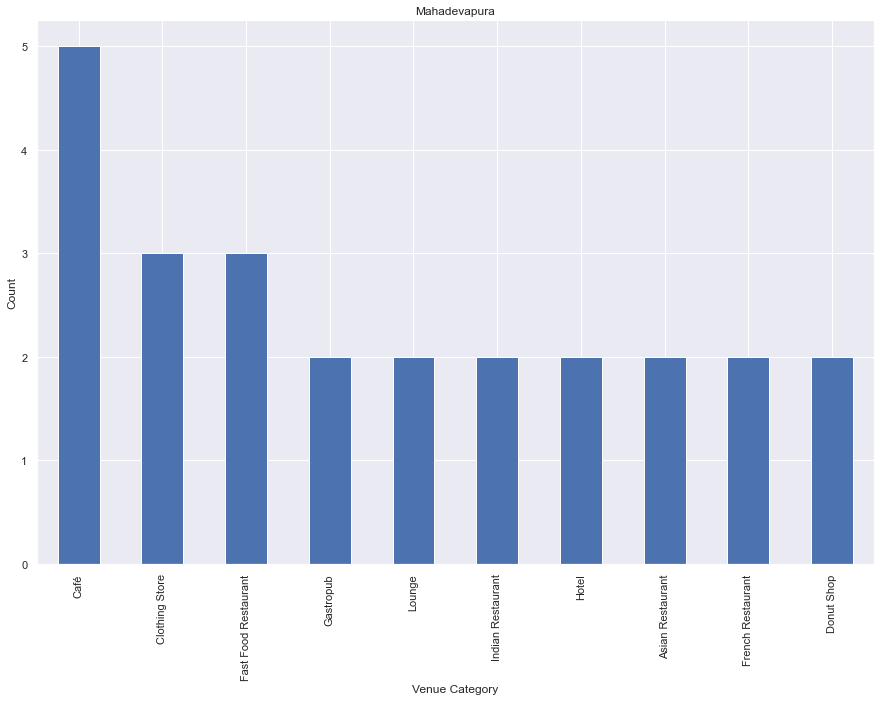

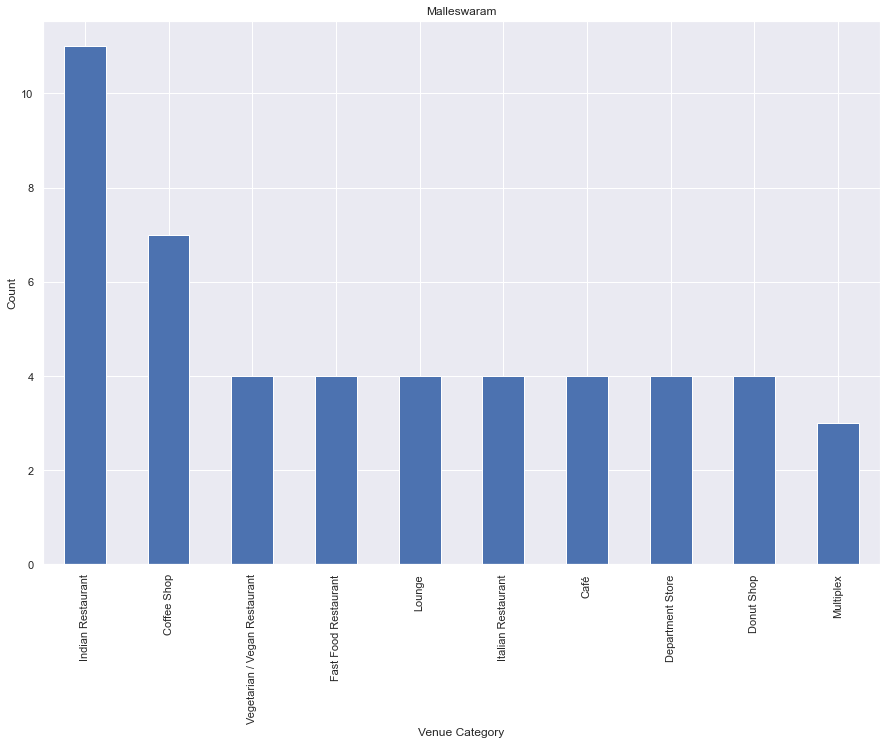

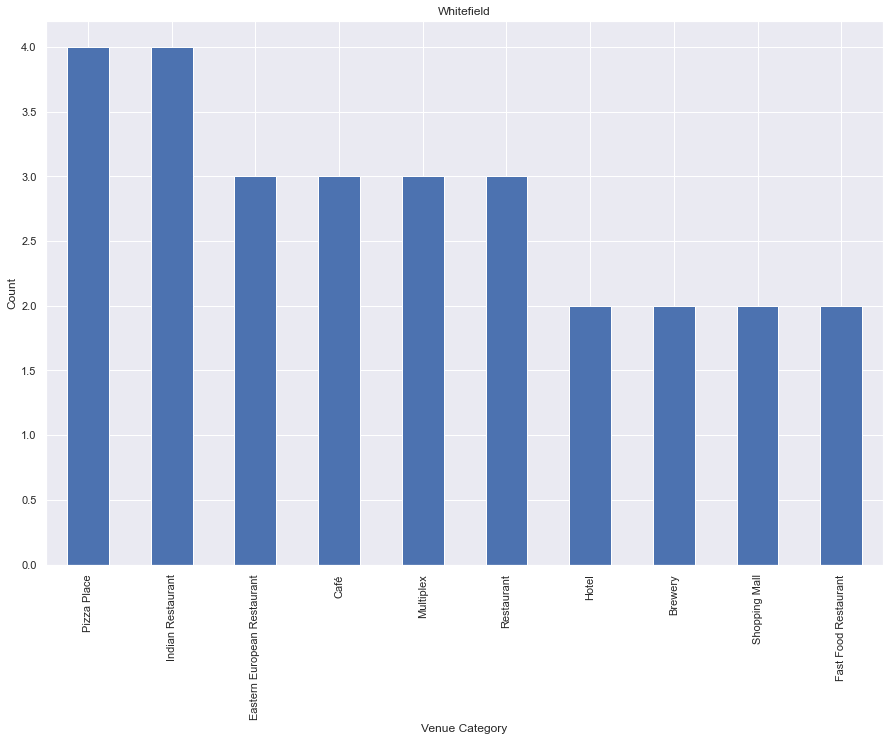

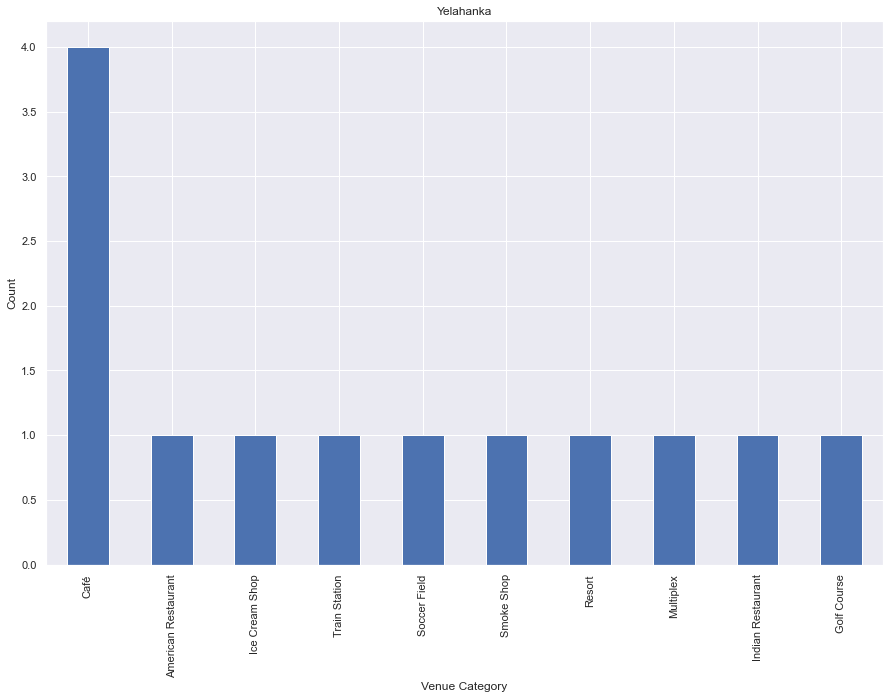

In [123]:
for nhood in all_nhoods:
    grp = venue_grps.get_group(nhood)
    analyze_nhood(grp)
    mv = map_nhood(grp)

In [91]:
#example map for Yelahanka
mv

## Step 3
Analyze Zomato Data for restaurants which includes cost, ratings, votes etc for the neighborhoods
1. avg statistics by neighborhoods
2. For each nhood, avg statistics by categories

In [92]:
zomato_df = pd.read_csv('zomato_restaurants_in_India.csv')
zomato_df.head()

,res_id,name,establishment,url,address,city,city_id,locality,latitude,longitude,...,price_range,currency,highlights,aggregate_rating,rating_text,votes,photo_count,opentable_support,delivery,takeaway
0,3400299,Bikanervala,['Quick Bites'],https://www.zomato.com/agra/bikanervala-khanda...,"Kalyani Point, Near Tulsi Cinema, Bypass Road,...",Agra,34,Khandari,27.211450,78.002381,...,2,Rs.,"['Lunch', 'Takeaway Available', 'Credit Card',...",4.4,Very Good,814,154,0.0,-1,-1
1,3400005,Mama Chicken Mama Franky House,['Quick Bites'],https://www.zomato.com/agra/mama-chicken-mama-...,"Main Market, Sadar Bazaar, Agra Cantt, Agra",Agra,34,Agra Cantt,27.160569,78.011583,...,2,Rs.,"['Delivery', 'No Alcohol Available', 'Dinner',...",4.4,Very Good,1203,161,0.0,-1,-1
2,3401013,Bhagat Halwai,['Quick Bites'],https://www.zomato.com/agra/bhagat-halwai-2-sh...,"62/1, Near Easy Day, West Shivaji Nagar, Goalp...",Agra,34,Shahganj,27.182938,77.979684,...,1,Rs.,"['No Alcohol Available', 'Dinner', 'Takeaway A...",4.2,Very Good,801,107,0.0,1,-1
3,3400290,Bhagat Halwai,['Quick Bites'],https://www.zomato.com/agra/bhagat-halwai-civi...,"Near Anjana Cinema, Nehru Nagar, Civil Lines, ...",Agra,34,Civil Lines,27.205668,78.004799,...,1,Rs.,"['Takeaway Available', 'Credit Card', 'Lunch',...",4.3,Very Good,693,157,0.0,1,-1
4,3401744,The Salt Cafe Kitchen & Bar,['Casual Dining'],https://www.zomato.com/agra/the-salt-cafe-kitc...,"1C,3rd Floor, Fatehabad Road, Tajganj, Agra",Agra,34,Tajganj,27.157709,78.052421,...,3,Rs.,"['Lunch', 'Serves Alcohol', 'Cash', 'Credit Ca...",4.9,Excellent,470,291,0.0,1,-1


In [94]:
columns = ['name','establishment','address','city','locality','latitude', 'longitude', 'locality_verbose', 'cuisines', 'average_cost_for_two',
       'price_range', 'aggregate_rating', 'votes', 'photo_count' ]
zomato_df = zomato_df[columns]
#Filter the data for Bangalore city and drop NA columns
zom_blr = zomato_df[zomato_df['city']=='Bangalore']
zom_blr = zom_blr.dropna()
def get_establishment(est):
    st = str(est.split('[')[1].split(']')[0])
    return(st[1:-1])
zom_blr['establishment'] = zom_blr['establishment'].apply(get_establishment)
zom_blr.head()

,name,establishment,address,city,locality,latitude,longitude,locality_verbose,cuisines,average_cost_for_two,price_range,aggregate_rating,votes,photo_count
19630,Biergarten,Pub,"4th B Cross, Koramangala 5th Block, Bangalore",Bangalore,Koramangala 5th Block,12.933427,77.614384,"Koramangala 5th Block, Bangalore","Continental, North Indian, Chinese, European, ...",2100,4,4.9,3632,2261
19631,Byg Brewski Brewing Company,Microbrewery,"22/123, Byrathi Village, Bidarahalli Hobli, He...",Bangalore,Hennur,13.070670,77.652806,"Hennur, Bangalore","Finger Food, Fast Food, North Indian, Italian",1600,3,4.7,7262,3000
19632,The Bangalore Cafe,Casual Dining,"4, KH Road, Double Road, Shanti Nagar, Bangalore",Bangalore,Shanti Nagar,12.961648,77.594516,"Shanti Nagar, Bangalore","Modern Indian, North Indian, Pizza, Continenta...",800,2,4.6,884,1183
19633,Stories - The Brew Chapter,Bar,"348/1/2, Survey 62, 29th Main, 2nd Stage, Lake...",Bangalore,BTM,12.905777,77.608377,"BTM, Bangalore","Bar Food, Continental, Chinese, Italian",2000,4,4.8,670,661
19634,Big Pitcher,Pub,"4121, LR Arcade, Old Airport Road, Bangalore",Bangalore,Old Airport Road,12.960138,77.646924,"Old Airport Road, Bangalore","American, Continental, North Indian, Mediterra...",1800,3,4.8,10652,6179


In [96]:
zom_blr = zom_blr[zom_blr['establishment']!='']
zom_blr = zom_blr[zom_blr['aggregate_rating']!=0]
zom_blr = zom_blr[zom_blr['average_cost_for_two']<10000]
def get_nhood(locality):
    nhood_list = []
    for n in all_nhoods:
        if(n in locality):
            return(n)
            pass
        pass
    return('NA')


zom_blr['neighborhood'] = zom_blr['locality'].apply(get_nhood)


In [110]:
zom_blr = zom_blr[zom_blr['neighborhood']!= 'NA']

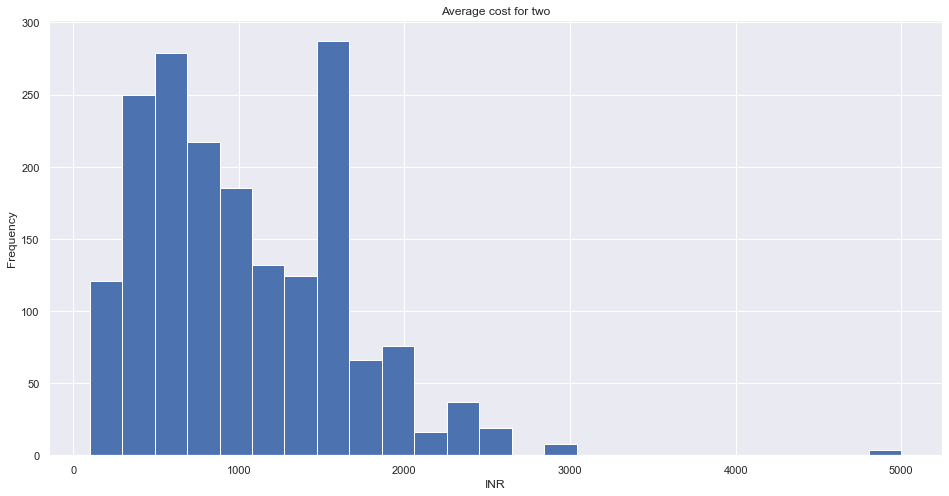

count    1821.000000
mean     1020.049423
std       618.540508
min       100.000000
25%       500.000000
50%       900.000000
75%      1500.000000
max      5000.000000
Name: average_cost_for_two, dtype: float64


In [111]:
# Average cost for two distribution
data = zom_blr['average_cost_for_two']
plt.figure(figsize=(16,8))
ax = data.plot(kind='hist', title = 'Average cost for two', bins = 25)
op = ax.set(xlabel ='INR')
plt.savefig('avg_cost.png')
plt.show()
print(data.describe())

In [130]:
def nhood_analysis_cat(name, grp):
    columns = ['average_cost_for_two', 'aggregate_rating', 'votes', 'photo_count']
    grps = grp.groupby(by='establishment')
    cat_means = grps.mean()[columns]
    for col in columns:
        plt.figure(figsize=(15,10))
        cat_means[col].sort_values(ascending=False).iloc[0:15].plot(kind='bar')
        plt.title(col + '-' + name)
        plt.savefig('bar_' + col + name + '.png' )
        plt.show()
def nhood_analysis(data):
    grps = data.groupby(by='neighborhood')
    columns = ['average_cost_for_two', 'aggregate_rating', 'votes', 'photo_count']
    cat_means = grps.mean()[columns]
    for col in columns:
        plt.figure(figsize=(15,10))
        cat_means[col].sort_values(ascending=False).plot(kind='bar')
        plt.title(col)
        plt.savefig('bar_' + col + '.png' )
        plt.show()
    for name, grp in grps:
        nhood_analysis_cat(name, grp)
    
    

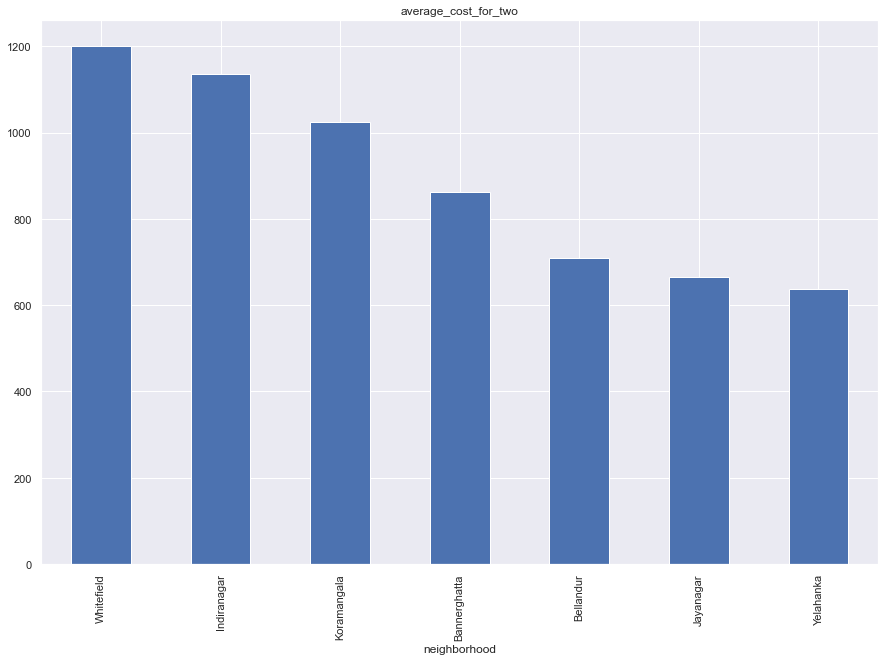

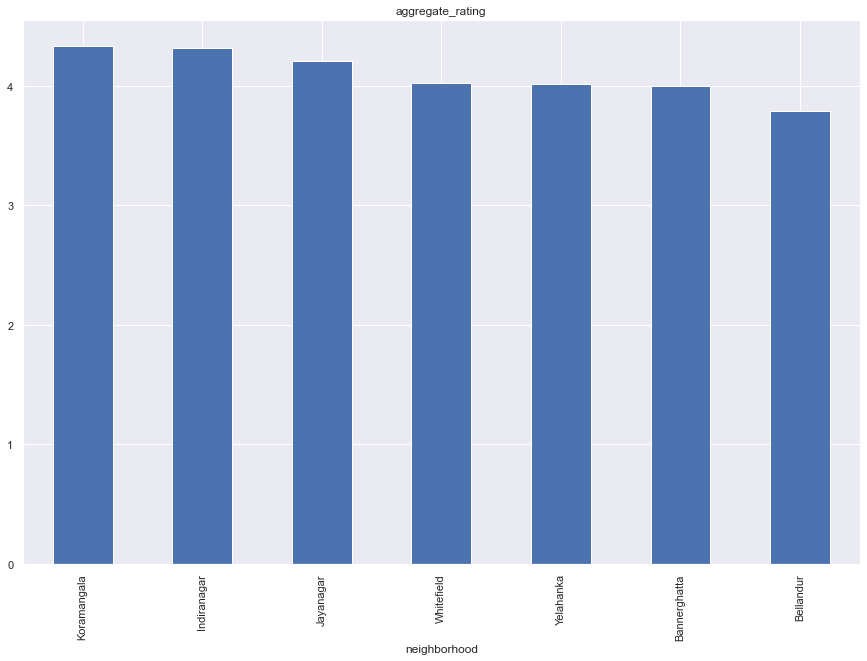

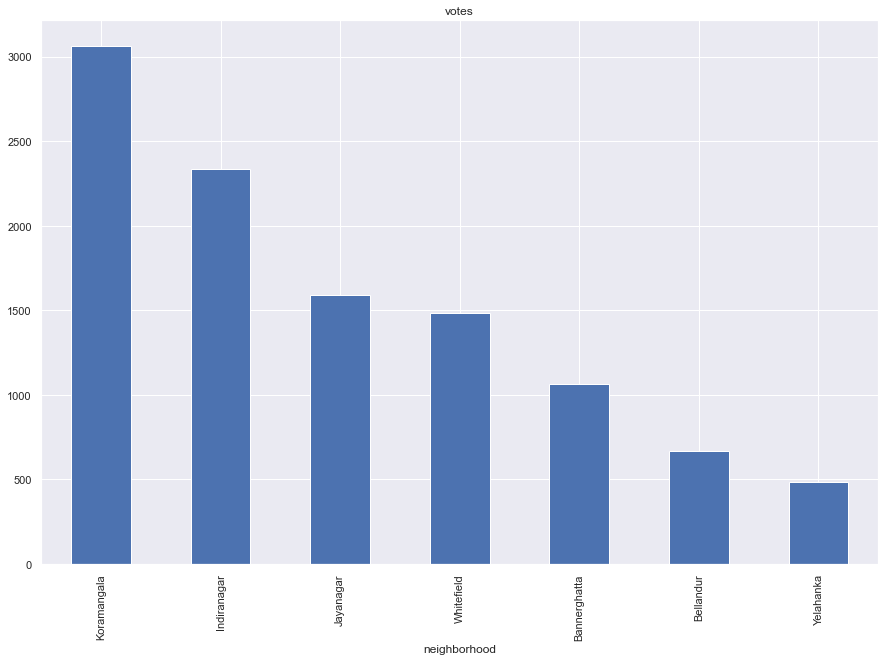

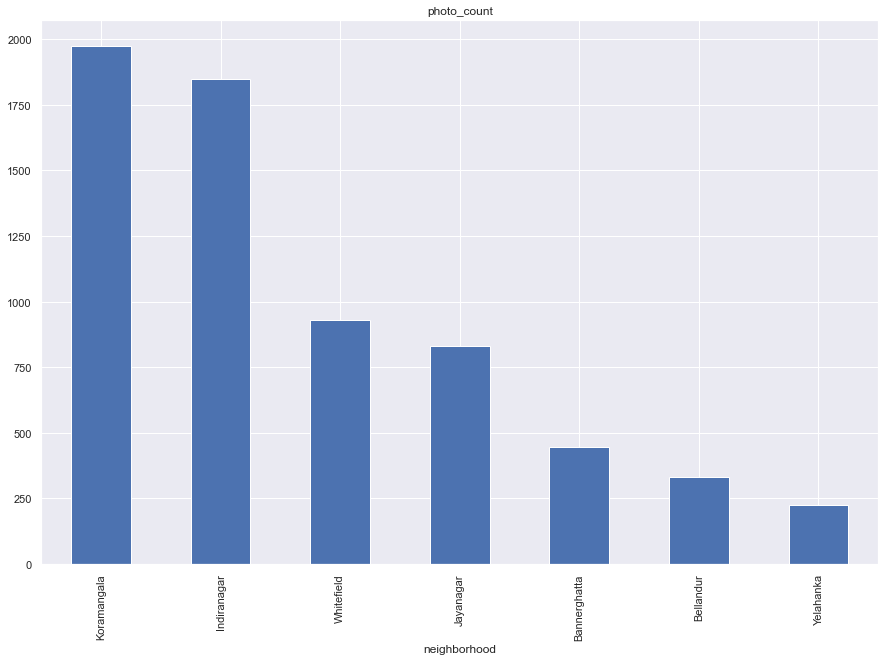

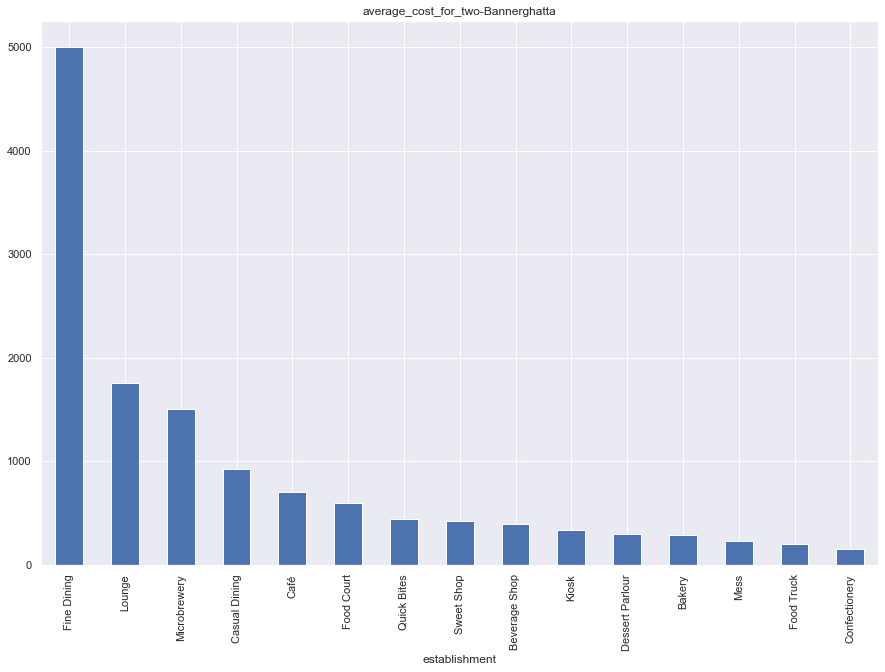

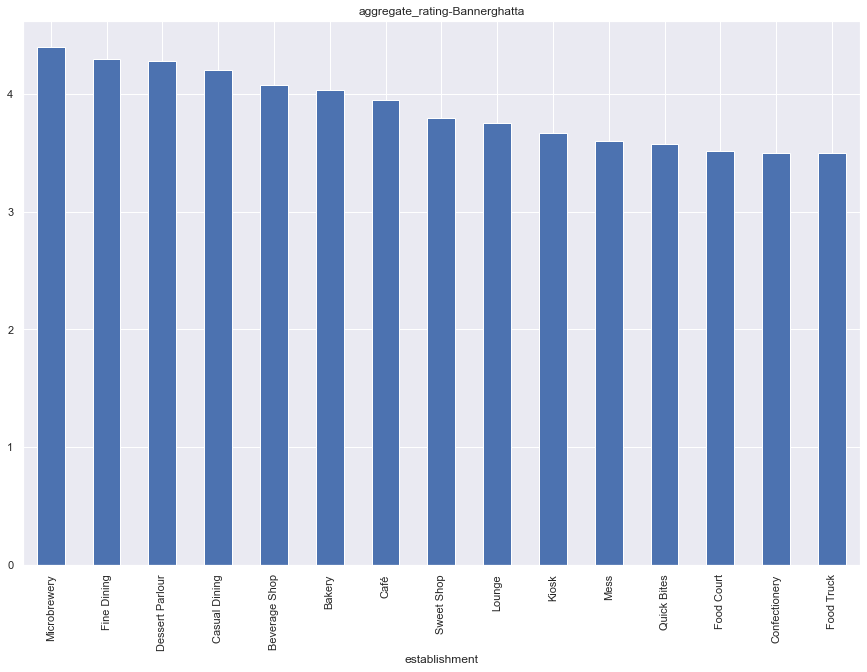

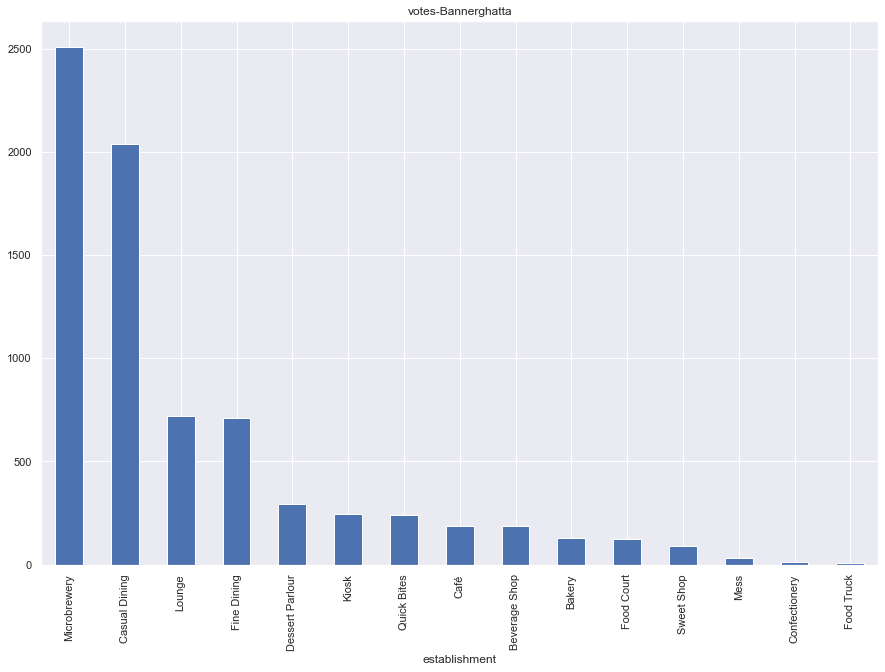

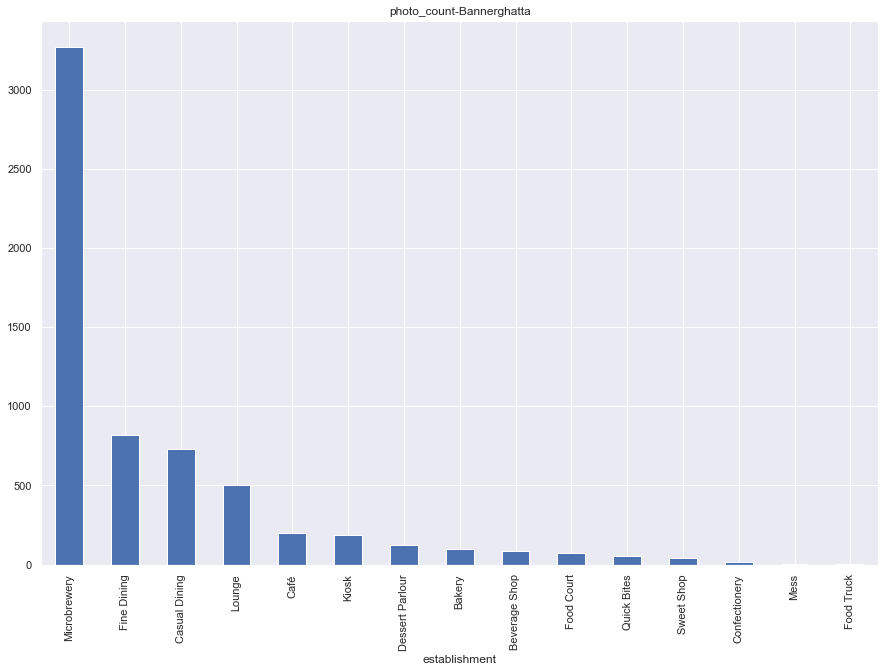

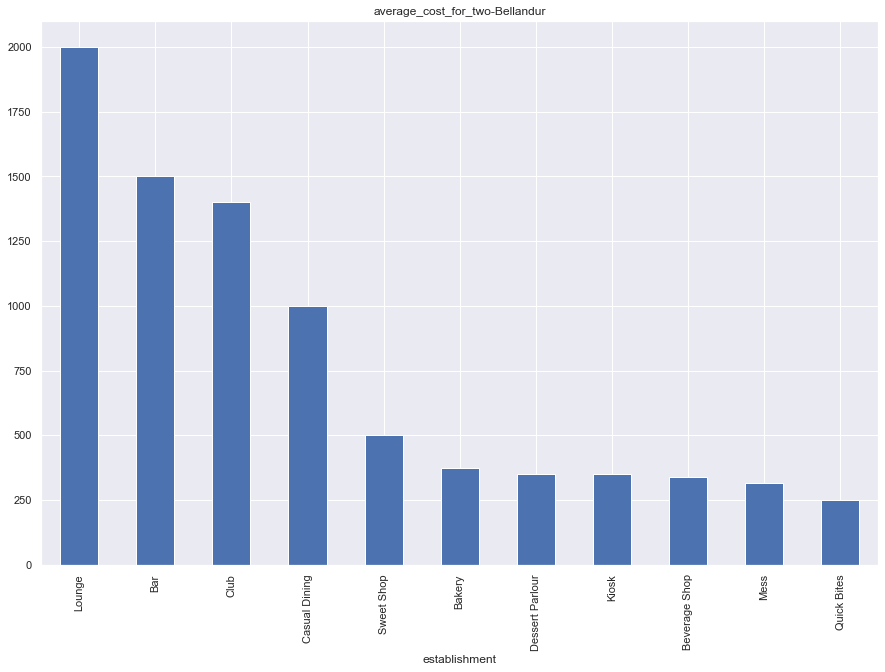

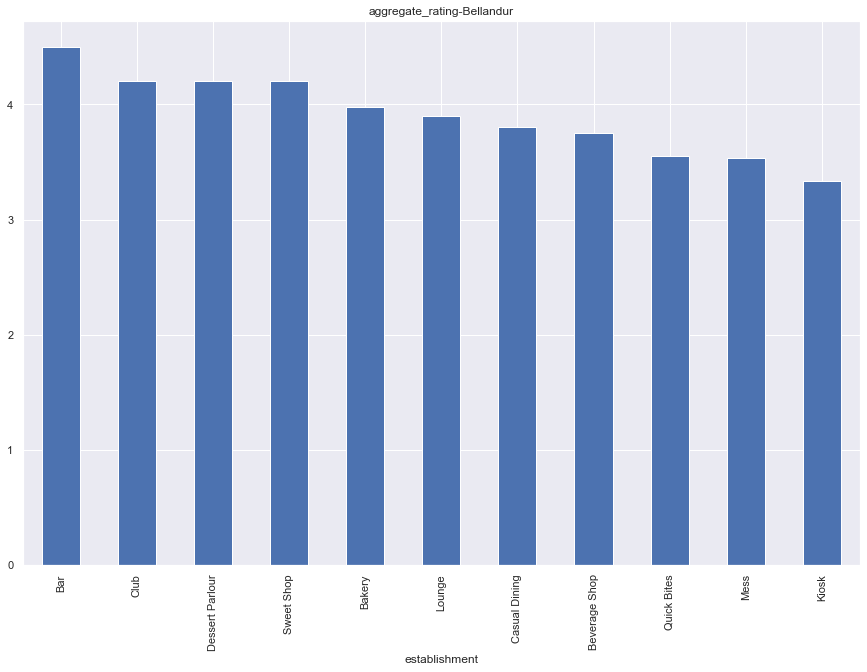

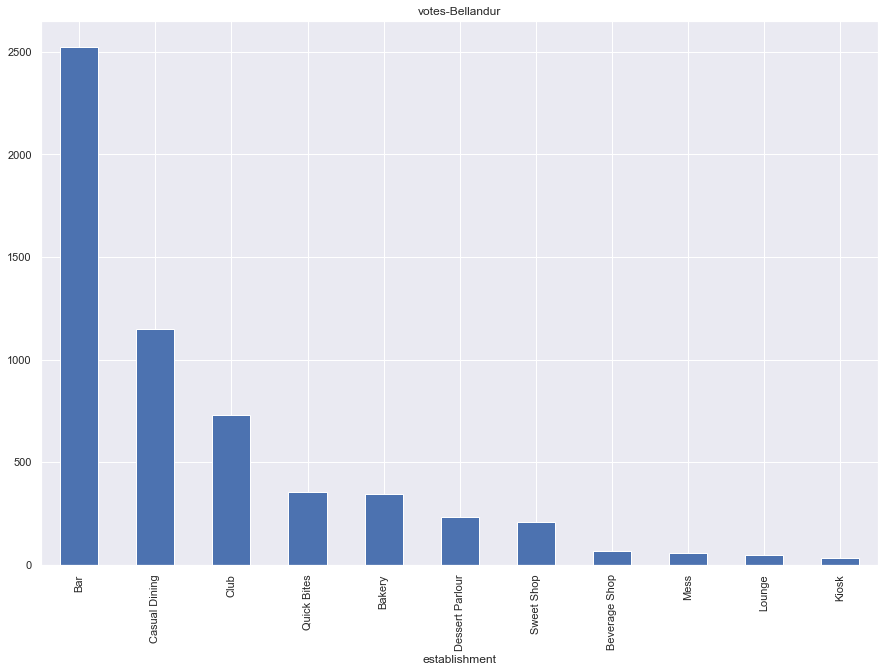

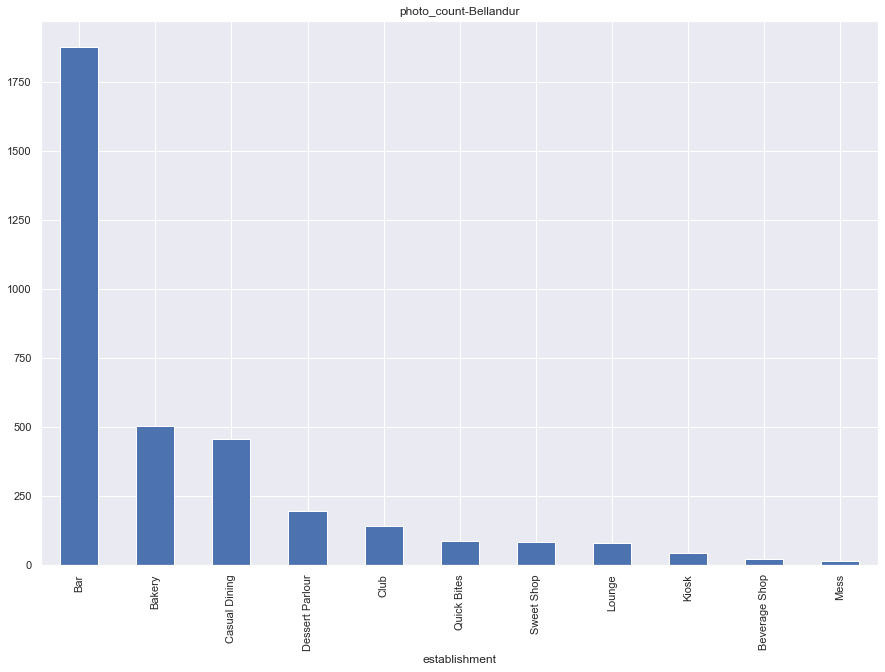

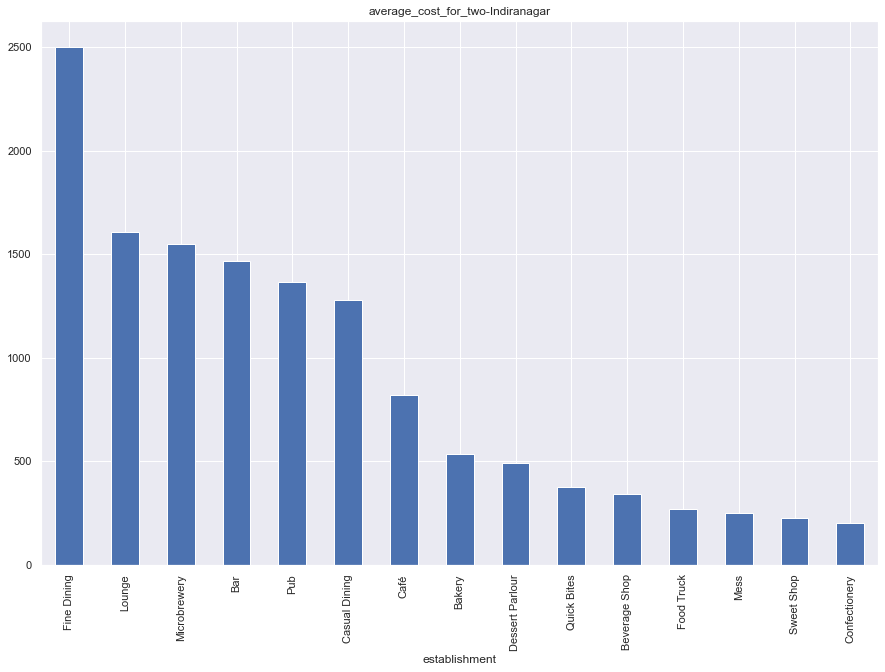

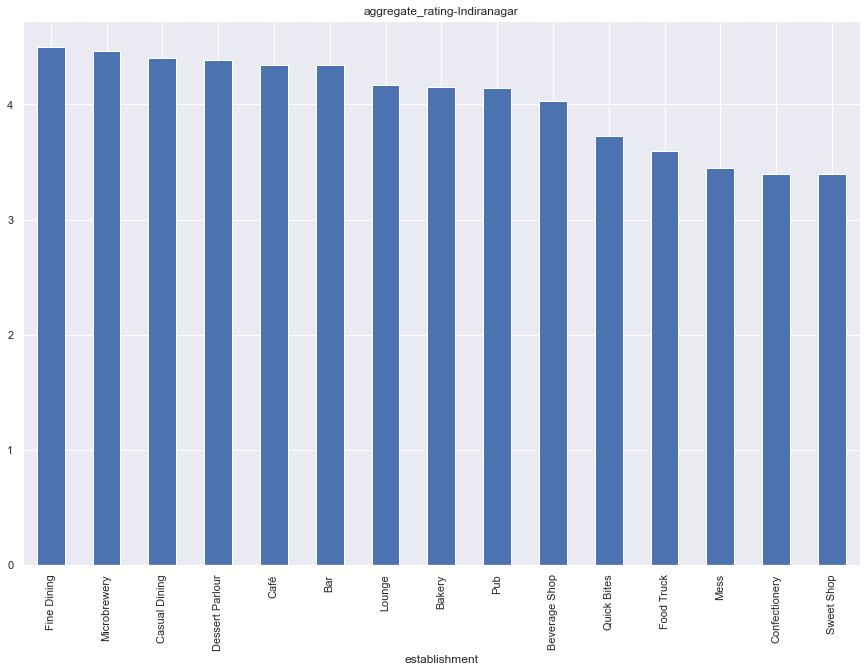

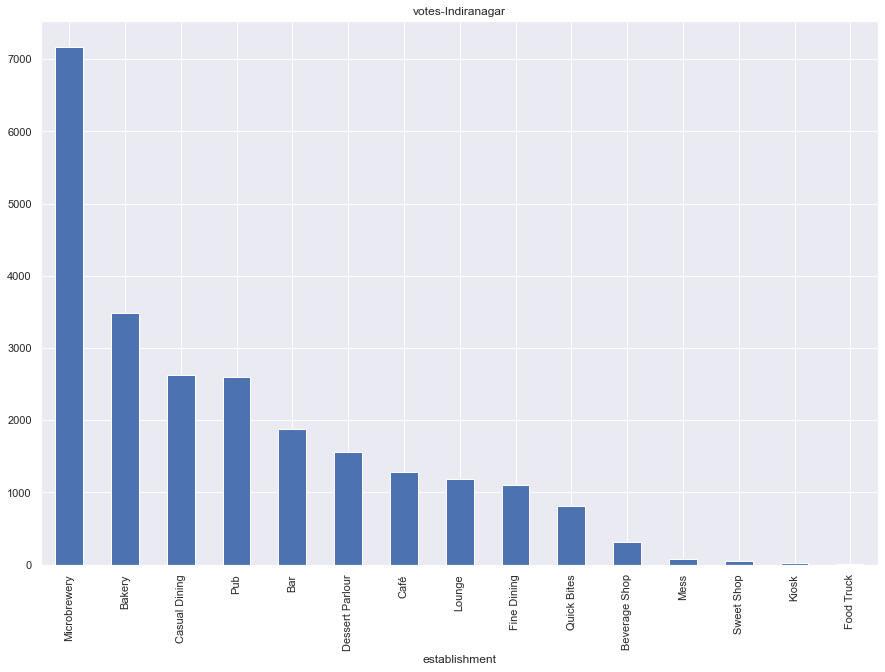

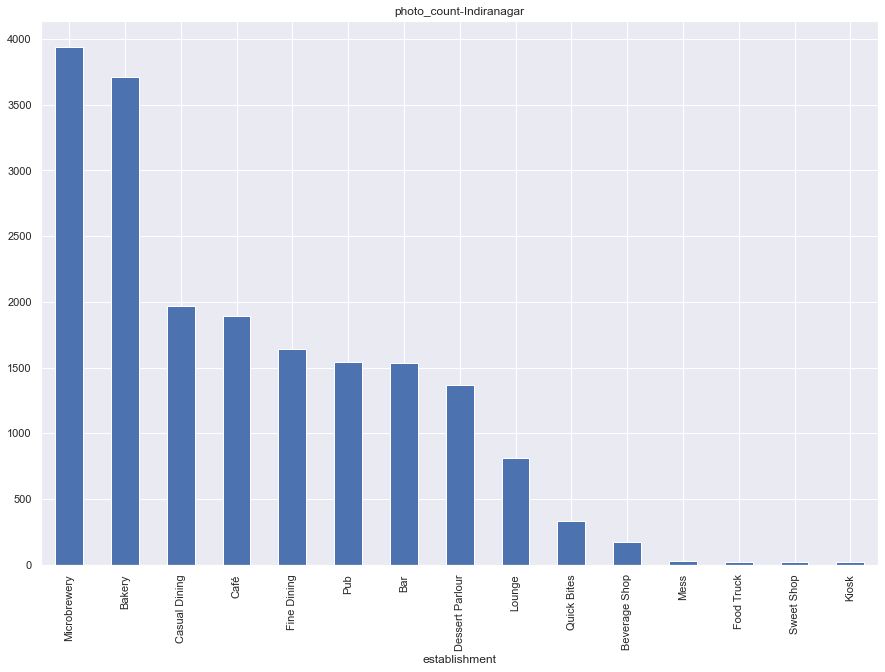

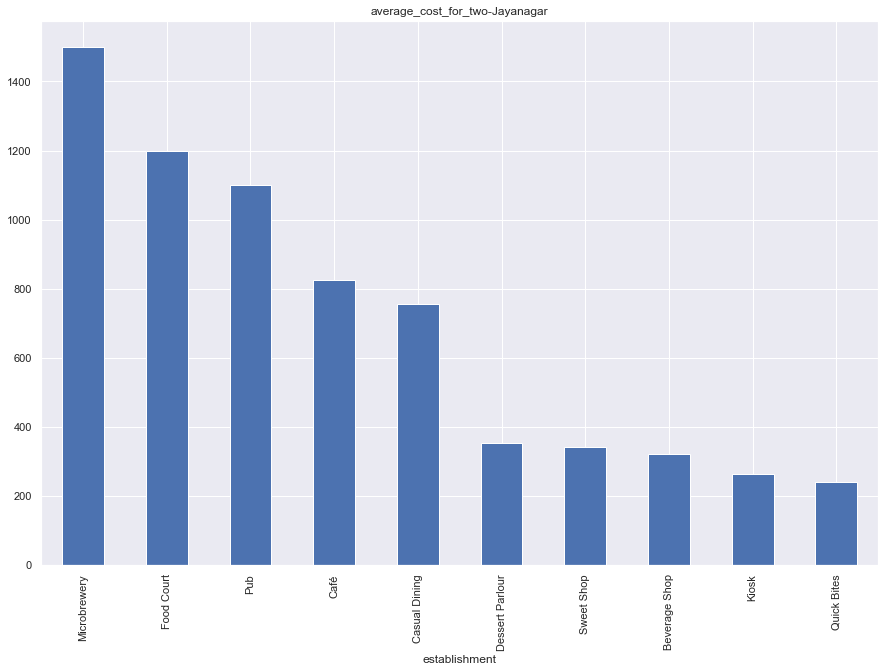

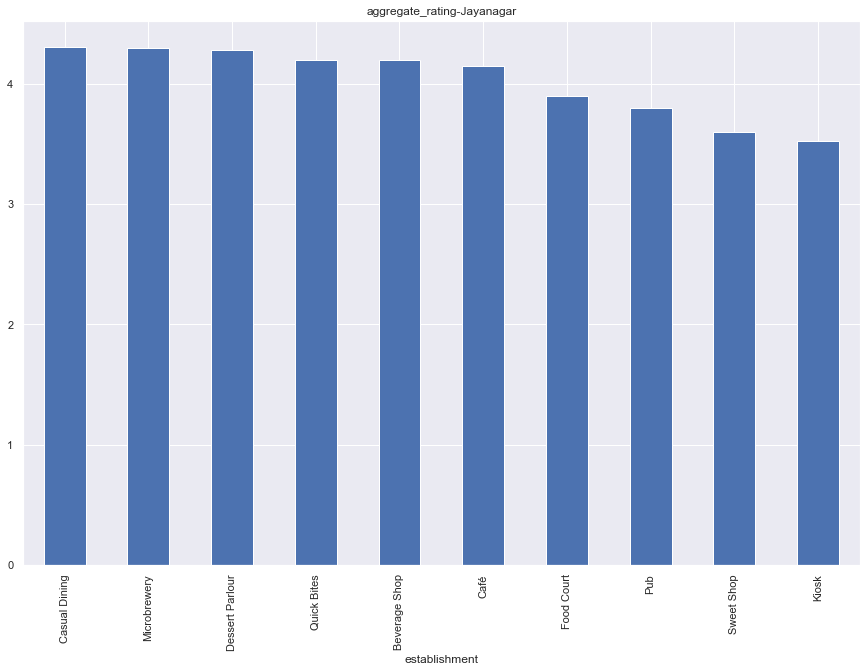

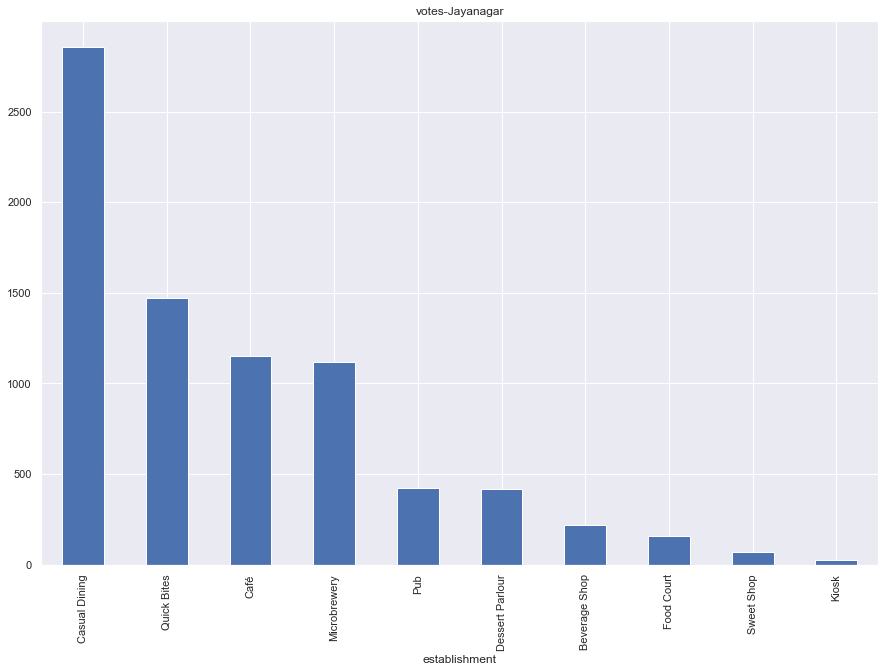

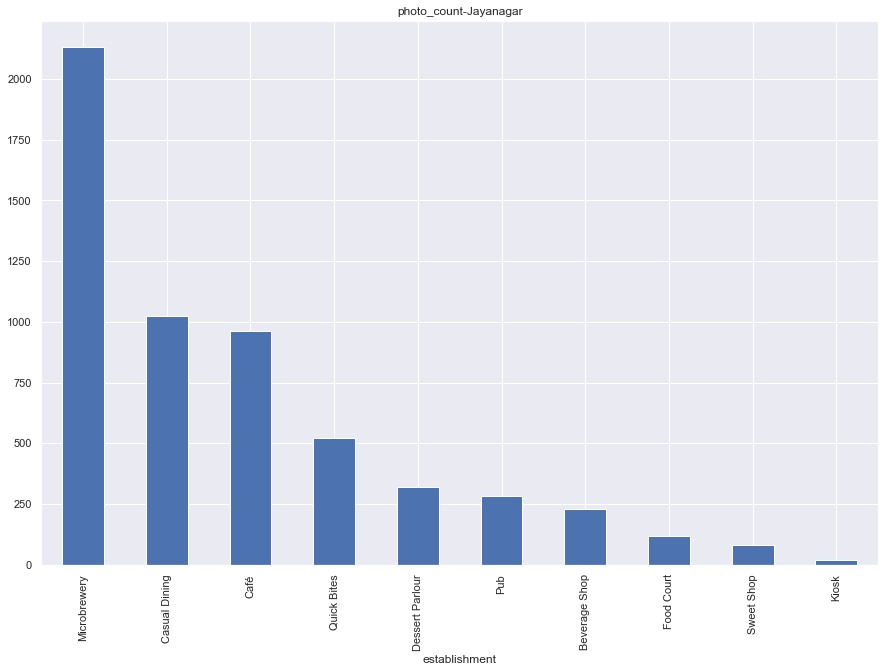

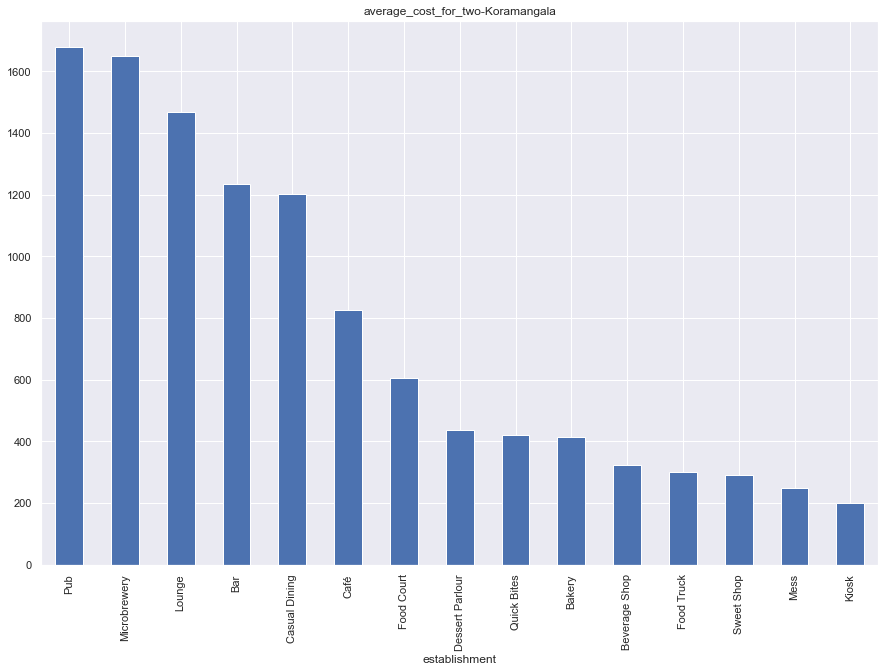

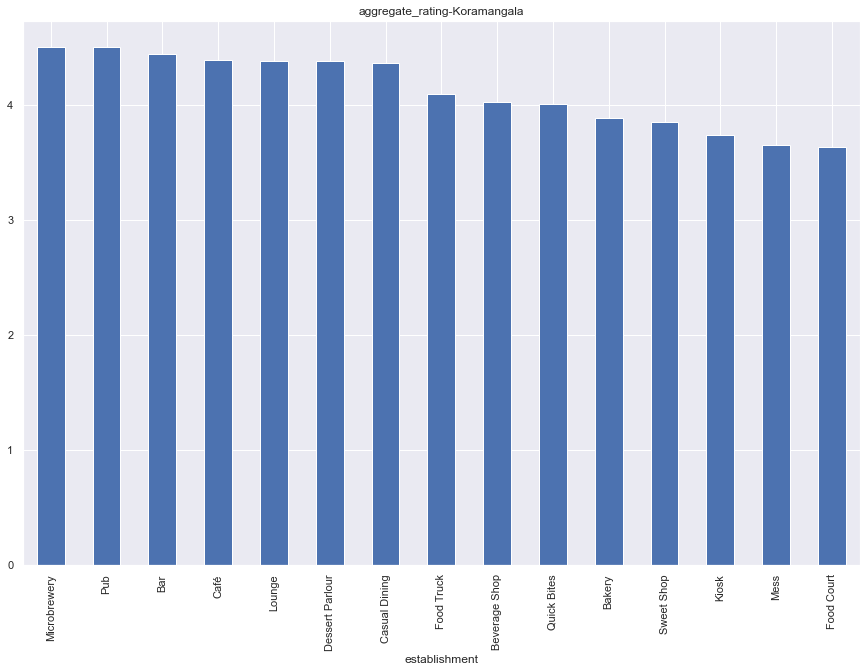

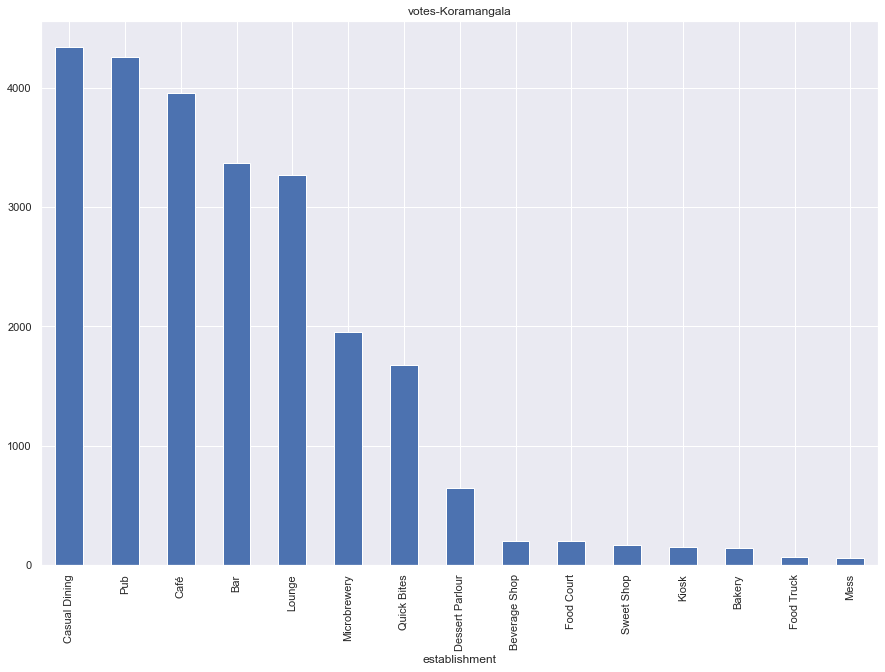

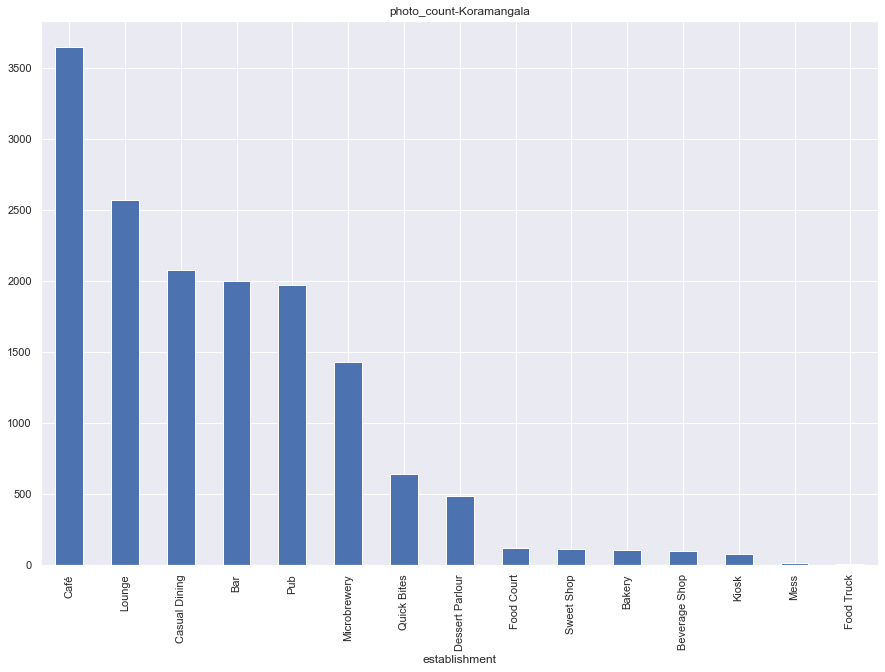

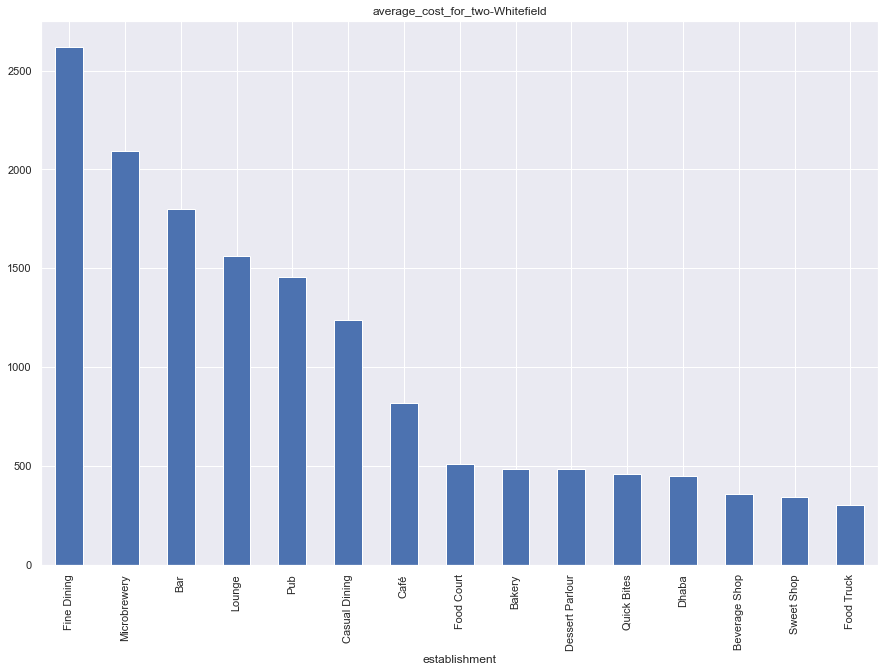

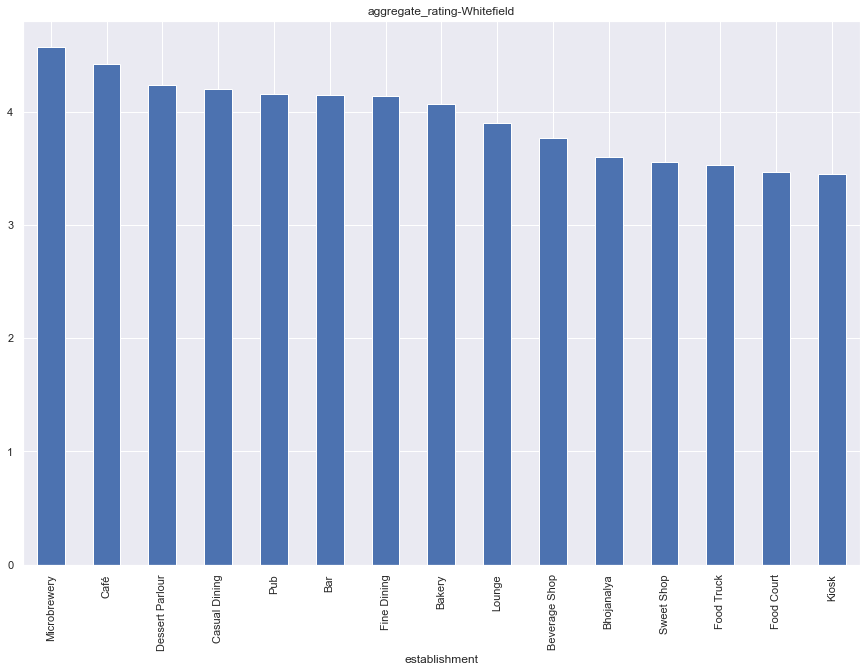

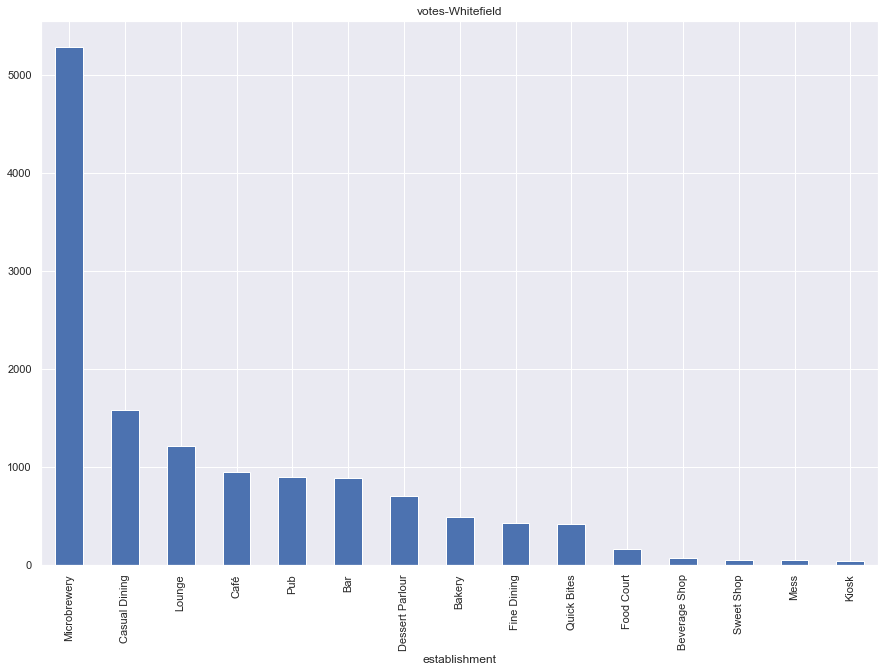

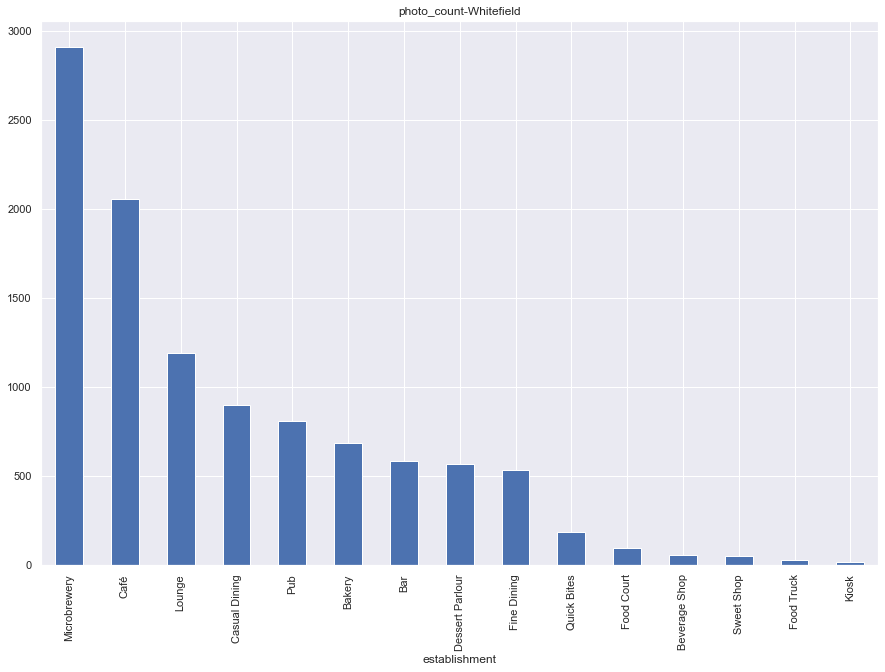

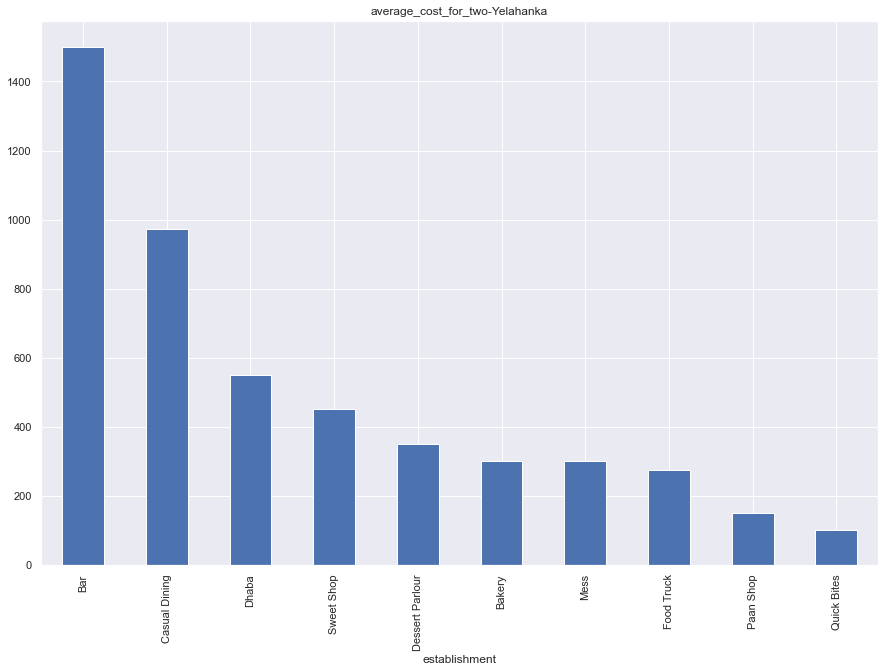

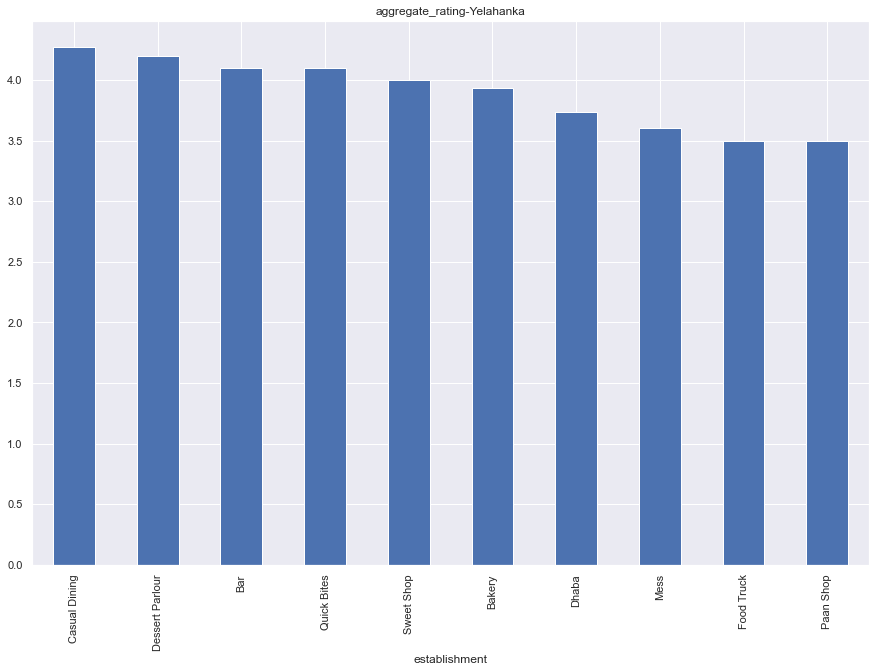

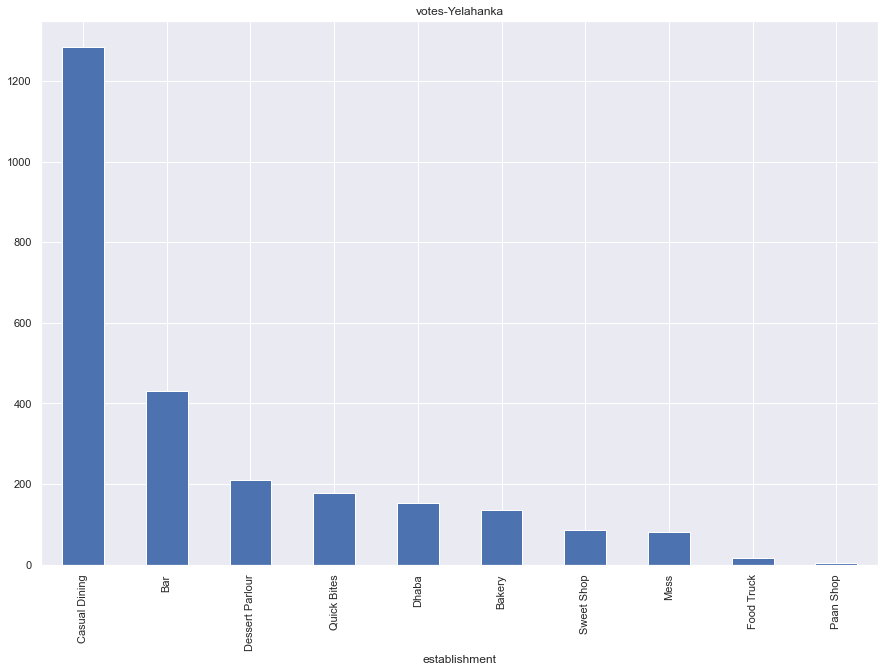

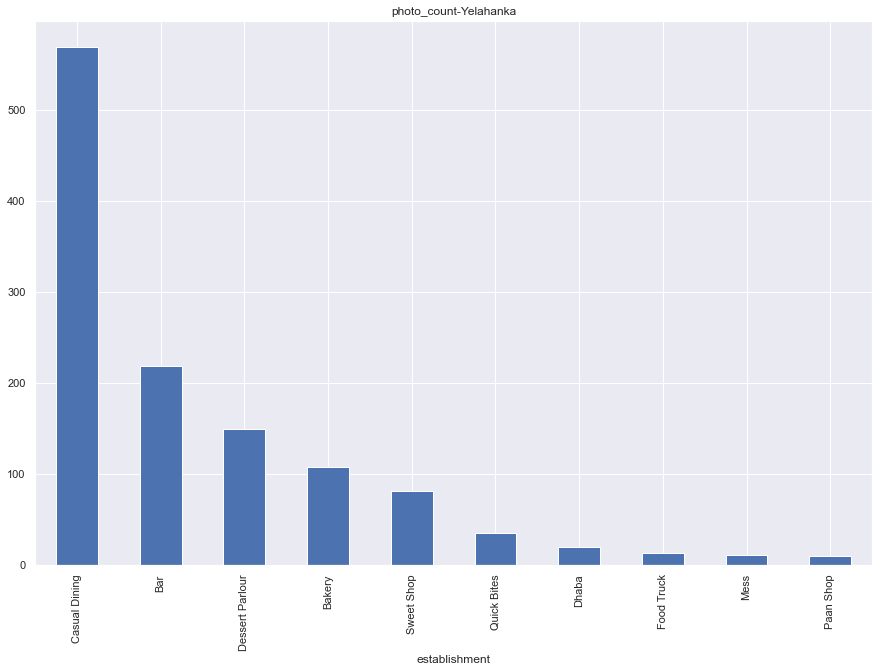

In [131]:
nhood_analysis(zom_blr)

In [134]:
def explore_nhood(est_cat, data):
    columns = ['average_cost_for_two', 'aggregate_rating', 'votes', 'photo_count']
    data = data[ data['establishment'] == est_cat ]
    grps = data.groupby(by='neighborhood')
    cat_means = grps.mean()[columns]
    for col in columns:
        plt.figure(figsize=(15,10))
        cat_means[col].sort_values(ascending=False).plot(kind='bar')
        plt.title(col + '-' + est_cat )
        plt.savefig('bar_' + col + '_' + est_cat + '.png' )
        plt.show()

In [181]:
est = zom_blr['establishment'].unique()[1]
print(est)

Microbrewery


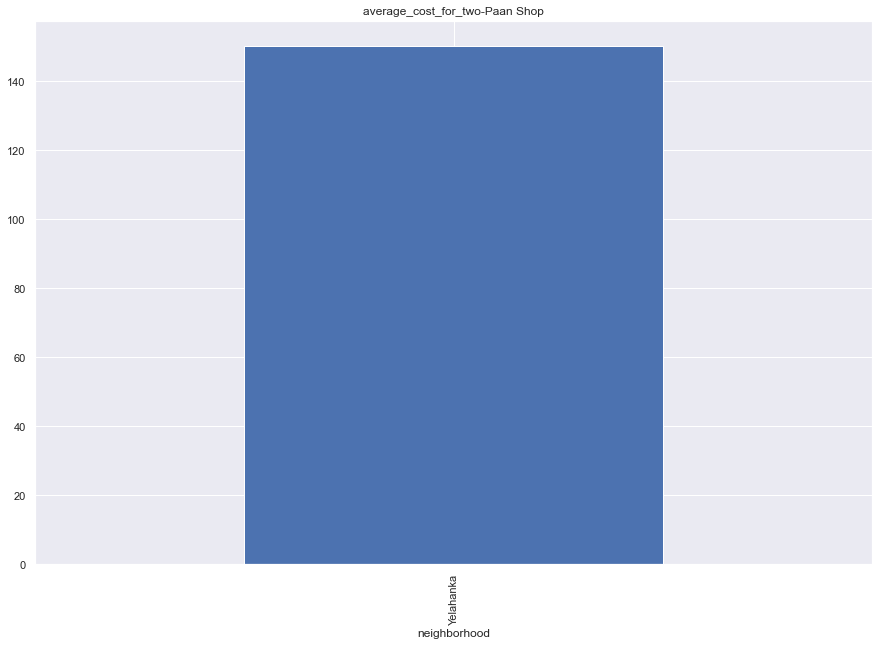

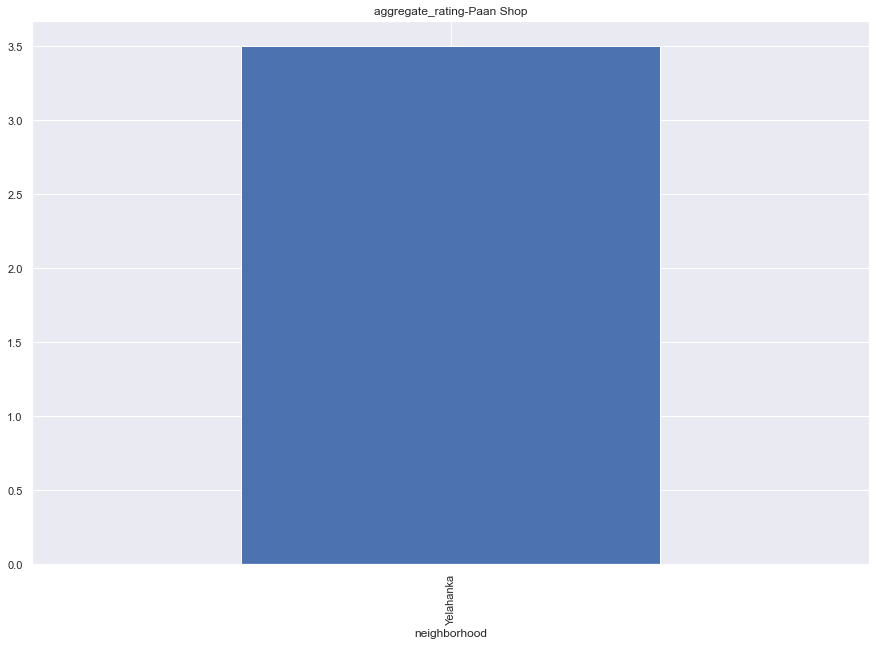

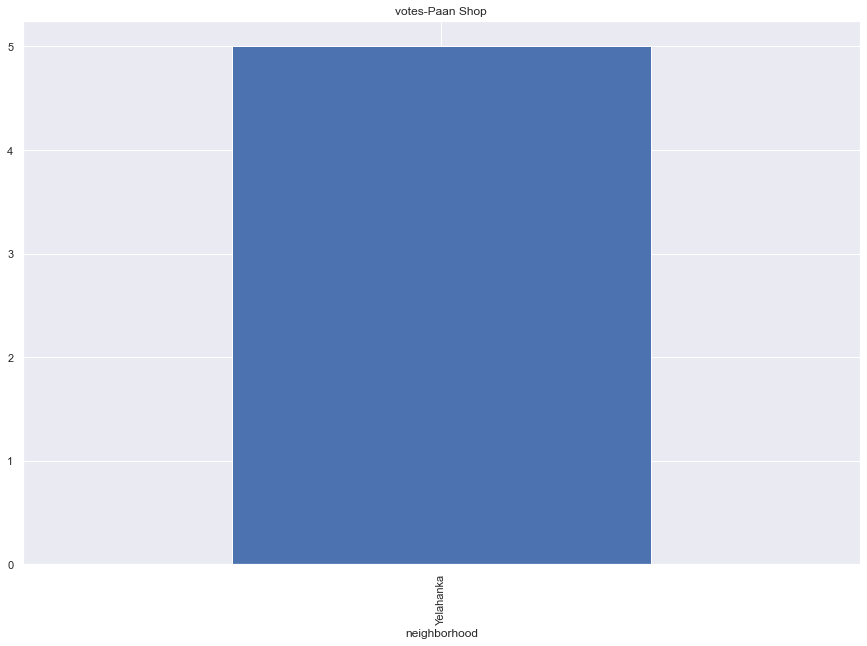

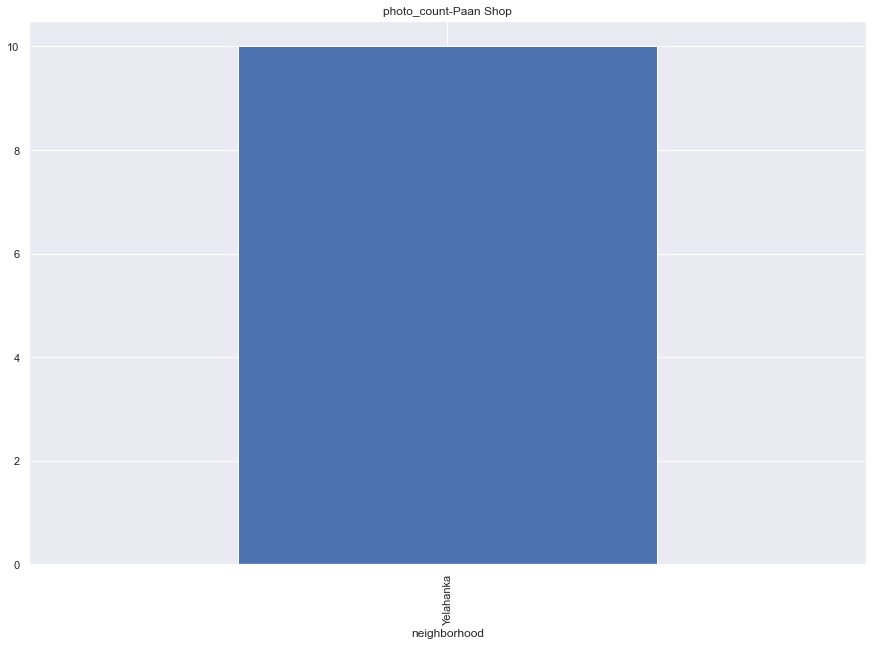

In [179]:
explore_nhood(est, zom_blr)